# ResNet50 image embedding and similarity search

In [1]:
import os
import sys
from typing import (
    List,
    Dict,
    Tuple,
    Union,
)
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

%matplotlib inline

In [2]:
sys.path.append("../../../lib")

In [56]:
%load_ext autoreload
%autoreload 2

from util_opencv.image import (
    validate_image,
    get_image,
    save_image,
    get_image_dimensions,
    resize_image,
    show_image,
    show_image_opencv,
    read_and_process_images,
    convert_bgr_to_rgb,
    resize
)
from util_numpy import (
    get_cosine_similarity,
    save,
    load,
)
from function import (
    ARG_LOG_LEVEL,
    ARG_SOURCE_DIR,
    ARG_TARGET_DIR,
    ARG_TARGET_FILE,
)
from util_tf.resnet50 import (
    RESNET50_IMAGE_HEIGHT,
    RESNET50_IMAGE_WIDTH,
    preprocess_rgb_image_for_resnet
)
from etl import (
    ETL
)
from feature_engineering import (
    FeatureEngineering
)
from train import (
    Vectorizer
)
from search import (
    ImageSearchEngine,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Resized RGB Images



In [4]:
resized_rgb: np.ndarray = np.load("../data/landing/resized_rgb.npy")
resized_rgb.shape

(4031, 224, 224, 3)

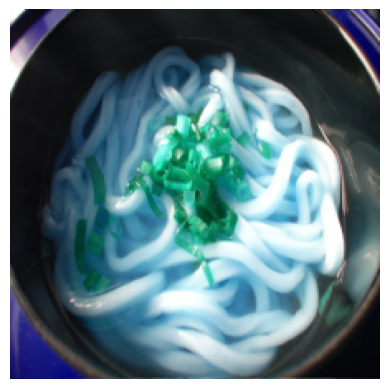

In [5]:
# show_image treats the image as BGR as per OpenCVS
show_image(resized_rgb[0])

## Feature Engineerd

In [6]:
feature_engineered: np.ndarray = np.load("../data/feature_store/feature_engineered.npy")
feature_engineered.shape

(4031, 224, 224, 3)

---

# Classification by ResNet50

* [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50)
* [tf.keras.applications.resnet50.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input)

> ```
> tf.keras.applications.resnet50.preprocess_input(
>    x, data_format=None
>)
> """
> Args:
>     x:  
>         A floating point numpy.array or a tf.Tensor, 3D or 4D with 3 color channels, 
>         with values in the range [0, 255]. The preprocessed data are written over 
>         the input data if the data types are compatible. To avoid this behaviour, 
>         numpy.copy(x) can be used.  
> Returns: Preprocessed numpy.array or a tf.Tensor with type float32.
> """
> ```

* [tf.keras.applications.resnet50.decode_predictions](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/decode_predictions)

> Returns: A list of lists of top class prediction tuples ```(class_name, class_description, score)```. One list of tuples per sample in batch input.



* [Usage examples for image classification models - Classify ImageNet classes with ResNet50](https://keras.io/api/applications/#usage-examples-for-image-classification-models)

> ```
> from tensorflow.keras.applications.resnet50 import ResNet50
> from tensorflow.keras.preprocessing import image
> from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
> import numpy as np
> 
> model = ResNet50(weights='imagenet')
> 
> img_path = 'elephant.jpg'
> img = image.load_img(img_path, target_size=(224, 224))
> x = image.img_to_array(img)
> x = np.expand_dims(x, axis=0)
> x = preprocess_input(x)
> 
> preds = model.predict(x)
> # decode the results into a list of tuples (class, description, probability)
> # (one such list for each sample in the batch)
> print('Predicted:', decode_predictions(preds, top=3)[0])
> # Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]
> ```

In [7]:
from keras.models import (
    Model, 
    Sequential
)
import tensorflow as tf
from tensorflow.keras.applications import (
#    ResNet152V2,
    ResNet50,
)
from tensorflow.keras.applications.resnet50 import (
     preprocess_input, 
     decode_predictions
 )

## Model

In [8]:
model: Model = ResNet50()

### Predict

In [9]:
decode_predictions(model.predict(feature_engineered[0:1]))

2023-01-23 18:11:22.074362: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 473ms/step


[[('n04263257', 'soup_bowl', 0.9638084),
  ('n07831146', 'carbonara', 0.014287933),
  ('n07714990', 'broccoli', 0.0057805534),
  ('n07584110', 'consomme', 0.0047541694),
  ('n07590611', 'hot_pot', 0.0024568008)]]

## Batch Predictions

### Load Images as RGB of shape (N, 224, 224, 3)

In [10]:
step: int = 10
predictions = decode_predictions(model.predict(feature_engineered[::step,]), top=3)
for index, pred in enumerate(predictions):
    print(index, pred)

13/13 [==============================] - 12s 879ms/step
0 [('n04263257', 'soup_bowl', 0.96380866), ('n07831146', 'carbonara', 0.014287813), ('n07714990', 'broccoli', 0.005780516)]
1 [('n07579787', 'plate', 0.76719064), ('n07583066', 'guacamole', 0.045539215), ('n07697537', 'hotdog', 0.038528513)]
2 [('n02776631', 'bakery', 0.7832293), ('n07875152', 'potpie', 0.0644003), ('n04476259', 'tray', 0.050149072)]
3 [('n04263257', 'soup_bowl', 0.8377435), ('n07584110', 'consomme', 0.050771046), ('n07930864', 'cup', 0.012542519)]
4 [('n07716906', 'spaghetti_squash', 0.2249125), ('n07697537', 'hotdog', 0.15445204), ('n07717556', 'butternut_squash', 0.12349708)]
5 [('n07873807', 'pizza', 0.38208592), ('n04270147', 'spatula', 0.34398606), ('n04111531', 'rotisserie', 0.13415931)]
6 [('n07584110', 'consomme', 0.9964401), ('n07920052', 'espresso', 0.0030429175), ('n04263257', 'soup_bowl', 0.0002774758)]
7 [('n07697313', 'cheeseburger', 0.66923696), ('n07697537', 'hotdog', 0.28869516), ('n07880968', 'b

## Feature Extractor for image embedding

In [11]:
feature_extractor: Model = Model(
    inputs=model.input,
    outputs=model.get_layer("avg_pool").output
)

---

# Feature Extraction using ResNet50

In [12]:
vectorizer: Vectorizer = Vectorizer()

In [13]:
vectorizer.fit(feature_engineered)

In [14]:
embeddings: np.ndarray = vectorizer.transform(images=feature_engineered)

126/126 [==============================] - 108s 853ms/step


In [15]:
vectorizer.save("../data/img2vec_model")

INFO:tensorflow:Assets written to: ../data/img2vec_model/assets


INFO:tensorflow:Assets written to: ../data/img2vec_model/assets


In [16]:
vectorizer.transform(images=feature_engineered[:5])

1/1 [==============================] - 0s 169ms/step


array([[4.3461967e-01, 1.9681258e-01, 9.1521702e+00, ..., 2.8281298e-01,
        3.0370975e-01, 1.4963353e-01],
       [0.0000000e+00, 7.0820916e-01, 1.8530014e+00, ..., 3.3603770e-01,
        2.5703628e+00, 5.2576476e-01],
       [6.8134850e-01, 0.0000000e+00, 6.0498154e-01, ..., 5.3970772e-01,
        1.5646758e+00, 7.4012917e-01],
       [3.5814572e-02, 9.0514049e-02, 4.7088094e+00, ..., 1.3125429e-04,
        1.0036511e-01, 6.8137841e-04],
       [2.6331853e-02, 1.2045666e+00, 5.5481019e+00, ..., 4.9647406e-01,
        2.7928433e+00, 6.1725091e-02]], dtype=float32)

In [17]:
vectorizer.load("../data/img2vec_model")

In [18]:
vectorizer.transform(images=feature_engineered[:5])

1/1 [==============================] - 0s 483ms/step


array([[4.3461967e-01, 1.9681258e-01, 9.1521702e+00, ..., 2.8281298e-01,
        3.0370975e-01, 1.4963353e-01],
       [0.0000000e+00, 7.0820916e-01, 1.8530014e+00, ..., 3.3603770e-01,
        2.5703628e+00, 5.2576476e-01],
       [6.8134850e-01, 0.0000000e+00, 6.0498154e-01, ..., 5.3970772e-01,
        1.5646758e+00, 7.4012917e-01],
       [3.5814572e-02, 9.0514049e-02, 4.7088094e+00, ..., 1.3125429e-04,
        1.0036511e-01, 6.8137841e-04],
       [2.6331853e-02, 1.2045666e+00, 5.5481019e+00, ..., 4.9647406e-01,
        2.7928433e+00, 6.1725091e-02]], dtype=float32)

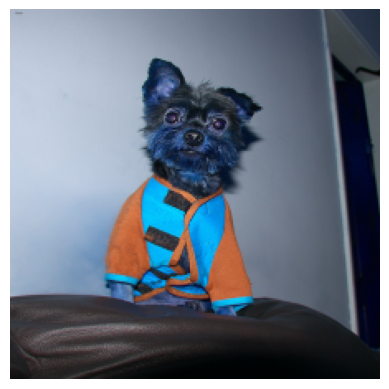

In [19]:
show_image(resized_rgb[1360])

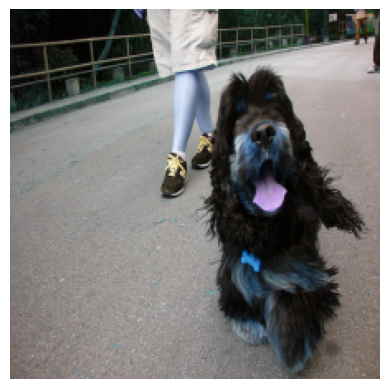

In [20]:
show_image(resized_rgb[1370])

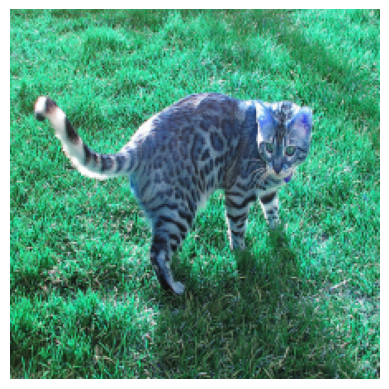

In [21]:
show_image(resized_rgb[1371])

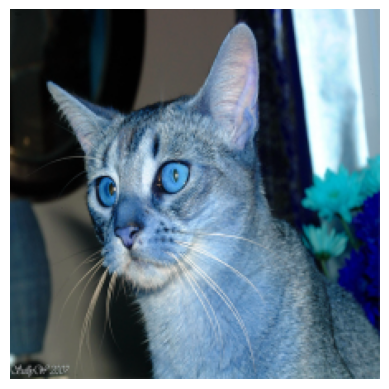

In [22]:
show_image(resized_rgb[1311])

# Similarities

In [23]:
get_cosine_similarity(x=embeddings[1370], y=embeddings[1360])

array([[0.44402575]], dtype=float32)

In [24]:
get_cosine_similarity(x=embeddings[1370], y=embeddings[1371])

array([[0.25445065]], dtype=float32)

In [25]:
get_cosine_similarity(x=embeddings[1311], y=embeddings[1371])

array([[0.35556084]], dtype=float32)

In [26]:
image_names: np.ndarray = np.load("../data/landing/image_names.npy")
image_names.shape

(4031,)

In [27]:
search = ImageSearchEngine(
    image_vectors=embeddings,
    path_to_vectorizer_model="../data/img2vec_model",
    images=resized_rgb,
    image_names=image_names
)

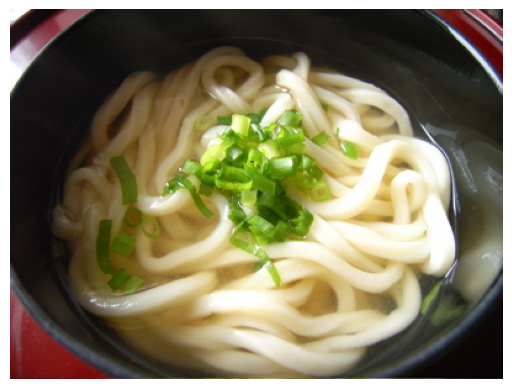

In [48]:
img = get_image(path="/Users/oonisim/home/repository/git/oonisim/python-programs/tensorflow/cnn/data/original/00000.jpg")
show_image(img)

In [55]:
get_image_dimensions(img)

(300, 400, 3)

In [63]:
result = resize(img, height=224, width=224)
resized = result['image']
resized.shape

(224, 224, 3)

In [69]:
resized_rgb_feature_engineerd = preprocess_rgb_image_for_resnet(resized)

In [75]:
resized_rgb_feature_engineerd_vectorized = vectorizer.transform(images=resized_rgb_feature_engineerd)
resized_rgb_feature_engineerd_vectorized

1/1 [==============================] - 0s 48ms/step


array([[0.4346197 , 0.19681261, 9.15217   , ..., 0.28281304, 0.30370972,
        0.14963353]], dtype=float32)

In [74]:
embeddings[0]

array([0.43461967, 0.19681258, 9.15217   , ..., 0.28281298, 0.30370975,
       0.14963353], dtype=float32)

In [29]:
similarities = search.cosine_similarity(embeddings[0], embeddings)

In [37]:
search.cosine_similarity(embeddings[0], embeddings[0][np.newaxis, :])

array([[1.]], dtype=float32)

In [77]:
search.transform(img)

1/1 [==============================] - 0s 49ms/step


array([[0.4346197 , 0.19681261, 9.15217   , ..., 0.28281304, 0.30370972,
        0.14963353]], dtype=float32)

In [50]:
search.transform()

1/1 [==============================] - 0s 50ms/step


array([[1.4900731 , 0.31354597, 3.2525916 , ..., 0.09559908, 0.48656934,
        0.34884906]], dtype=float32)

In [47]:
vectorizer.transform(feature_engineered[:1])

1/1 [==============================] - 0s 49ms/step


array([[0.4346197 , 0.19681261, 9.15217   , ..., 0.28281304, 0.30370972,
        0.14963353]], dtype=float32)

In [30]:
a = np.squeeze(similarities)

In [31]:
indices = np.argsort(a, axis=-1)[::-1][:5]

In [32]:
a[indices]

array([1.        , 0.71903044, 0.692385  , 0.68901646, 0.6858365 ],
      dtype=float32)

In [78]:
search.most_similar(query=img)

1/1 [==============================] - 0s 49ms/step


INFO:search:most_similar(): similar images [(1.0, '00000.jpg'), (0.7190304398536682, '00543.jpg'), (0.6923849582672119, '00738.jpg'), (0.6890164613723755, '00577.jpg'), (0.6858364343643188, '00626.jpg')]


[1.         0.49718952 0.33216986 0.37714398 0.64156646]
indices [  0 543 738 577 626] similarties[0] [1.         0.49718952 0.33216986 0.37714398 0.64156646]
scores: [1.0, 0.7190304398536682, 0.6923849582672119, 0.6890164613723755, 0.6858364343643188]


[(1.0, '00000.jpg'),
 (0.7190304398536682, '00543.jpg'),
 (0.6923849582672119, '00738.jpg'),
 (0.6890164613723755, '00577.jpg'),
 (0.6858364343643188, '00626.jpg')]

In [34]:
similarities.shape

(1, 4031)

In [35]:
a = np.array([1, 5, 3]).reshape(1, -1)
a.shape

(1, 3)

In [36]:
np.argsort(a, axis=-1)[0]

array([0, 2, 1])